# Learning Embeddings with Continuous Bag of Words (CBOW)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/cs39aa_notebooks/blob/main/misc/embeddings_w_frankenstein.ipynb)


## Imports

In [ ]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string
import tqdm

import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib 
import matplotlib.pyplot as plt

## Data Vectorization classes

### The Vocabulary

In [ ]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, mask_token="<MASK>", add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            mask_token (str): the MASK token to add into the Vocabulary; indicates
                a position that will not be used in updating the model's parameters
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
            
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        self._mask_token = mask_token
        
        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token, 
                'mask_token': self._mask_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [ ]:
class CBOWVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""    
    def __init__(self, cbow_vocab):
        """
        Args:
            cbow_vocab (Vocabulary): maps words to integers
        """
        self.cbow_vocab = cbow_vocab

    def vectorize(self, context, vector_length=-1):
        """
        Args:
            context (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector
        """

        indices = [self.cbow_vocab.lookup_token(token) for token in context.split(' ')]
        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.cbow_vocab.mask_index

        return out_vector
    
    @classmethod
    def from_dataframe(cls, cbow_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            cbow_df (pandas.DataFrame): the target dataset
        Returns:
            an instance of the CBOWVectorizer
        """
        cbow_vocab = Vocabulary()
        for index, row in cbow_df.iterrows():
            for token in row.context.split(' '):
                cbow_vocab.add_token(token)
            cbow_vocab.add_token(row.target)
            
        return cls(cbow_vocab)

    @classmethod
    def from_serializable(cls, contents):
        cbow_vocab = \
            Vocabulary.from_serializable(contents['cbow_vocab'])
        return cls(cbow_vocab=cbow_vocab)

    def to_serializable(self):
        return {'cbow_vocab': self.cbow_vocab.to_serializable()}

### The Dataset

In [ ]:
class CBOWDataset(Dataset):
    def __init__(self, cbow_df, vectorizer):
        """
        Args:
            cbow_df (pandas.DataFrame): the dataset
            vectorizer (CBOWVectorizer): vectorizer instatiated from dataset
        """
        self.cbow_df = cbow_df
        self._vectorizer = vectorizer
        
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, cbow_df.context))
        
        self.train_df = self.cbow_df[self.cbow_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.cbow_df[self.cbow_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.cbow_df[self.cbow_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, cbow_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            cbow_csv (str): location of the dataset
        Returns:
            an instance of CBOWDataset
        """
        cbow_df = pd.read_csv(cbow_csv)
        train_cbow_df = cbow_df[cbow_df.split=='train']
        return cls(cbow_df, CBOWVectorizer.from_dataframe(train_cbow_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, cbow_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            cbow_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of CBOWDataset
        """
        cbow_df = pd.read_csv(cbow_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(cbow_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of CBOWVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return CBOWVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer
        
    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        context_vector = \
            self._vectorizer.vectorize(row.context, self._max_seq_length)
        target_index = self._vectorizer.cbow_vocab.lookup_token(row.target)

        return {'x_data': context_vector,
                'y_target': target_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## The Model: Continuous-bag-of-Words Classifier

In [ ]:
class CBOWClassifier(nn.Module): # Simplified cbow Model
    def __init__(self, vocabulary_size, embedding_size, padding_idx=0):
        
        super(CBOWClassifier, self).__init__()
        
        self.embedding =  nn.Embedding(num_embeddings=vocabulary_size, 
                                       embedding_dim=embedding_size,
                                       padding_idx=padding_idx)



        # use these when we keep the embedding tensors separate, and flatten them into a rank-1 tensor that is 6x longer 
        self.bn = nn.BatchNorm1d(num_features=embedding_size * 6)        
        self.fc1 = nn.Linear(in_features=embedding_size * 6, out_features=vocabulary_size)

        # use these when we sum together the embedding tensors from the previous layer
        #self.bn = nn.BatchNorm1d(num_features=embedding_size * 6)        
        #self.fc1 = nn.Linear(in_features=embedding_size, out_features=vocabulary_size)

    def forward(self, x_in, apply_dropout=False, apply_softmax=False):

        # keep all 6 embeddings separate but flatten them into a lower-rank tensor
        x_interm = torch.flatten(self.embedding(x_in.long()), start_dim=1)

        # combine the 6 embeddings by takign their sum
        #x_interm = self.embedding(x_in.long()).sum(dim=1)        
        
        if apply_dropout:
            x_interm = F.dropout(x_interm, 0.6)
 
        x_interm = F.relu(x_interm)
        x_interm = self.bn(x_interm)
               
        y_out = self.fc1(x_interm)
        
        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)
            
        return y_out

## Training Routine

### Helper functions

In [ ]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

#### general utilities

In [ ]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### Settings and some prep work

In [ ]:
args = Namespace(
    # Data and Path information
    #cbow_csv="/Users/steve/icloud/MSU/Classes/CS39AA_2022fall/cs39aa_notebooks/data/frankenstein_with_splits.csv",
    cbow_csv="https://raw.githubusercontent.com/sgeinitz/cs39aa_notebooks/main/data/frankenstein_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="/Users/steve/models/frankenstein_cbow",
    # Model hyper parameters
    embedding_size=50,
    # Training hyper parameters
    seed=42,
    num_epochs=6,
    learning_rate=0.001,
    batch_size=500,
    early_stopping_criteria=5,
    # Runtime options
    cuda=False,
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	/Users/steve/models/frankenstein_cbow/vectorizer.json
	/Users/steve/models/frankenstein_cbow/model.pth
Using CUDA: False


### Initializations

In [ ]:
if args.reload_from_files:
    print("Loading dataset and loading vectorizer")
    dataset = CBOWDataset.load_dataset_and_load_vectorizer(args.cbow_csv,
                                                           args.vectorizer_file)
else:
    print("Loading dataset and creating vectorizer")
    dataset = CBOWDataset.load_dataset_and_make_vectorizer(args.cbow_csv)
    dataset.save_vectorizer(args.vectorizer_file)
    
vectorizer = dataset.get_vectorizer()

classifier = CBOWClassifier(vocabulary_size=len(vectorizer.cbow_vocab), 
                            embedding_size=args.embedding_size)


Loading dataset and creating vectorizer


In [ ]:
len(vectorizer.cbow_vocab)

6138

In [ ]:
print("first observation x data: ", dataset[0]['x_data'])
print("                y target: ", dataset[0]['y_target'])

first observation x data:  [2 3 4 0 0 0]
                y target:  5


In [ ]:
# Look at the first 10 tokens in the vocabulary
for i in range(10):
    print(f"vocab i = {i} is {vectorizer.cbow_vocab.lookup_index(i)}")

vocab i = 0 is <MASK>
vocab i = 1 is <UNK>
vocab i = 2 is ,
vocab i = 3 is or
vocab i = 4 is the
vocab i = 5 is frankenstein
vocab i = 6 is modern
vocab i = 7 is prometheus
vocab i = 8 is by
vocab i = 9 is mary


In [ ]:
[vectorizer.cbow_vocab.lookup_index(i) for i in dataset[0]['x_data']]

[',', 'or', 'the', '<MASK>', '<MASK>', '<MASK>']

In [ ]:
i = 0
print(f"obs[{i}] x data: {dataset[i]['x_data']}")
print(f"       y target: {dataset[i]['y_target']}")
print(f"To predict token: '{vectorizer.cbow_vocab.lookup_index(dataset[i]['y_target'])}' \n")
print(f"input tokens used are: \n   {[vectorizer.cbow_vocab.lookup_index(j) for j in dataset[i]['x_data']]}")

obs[0] x data: [2 3 4 0 0 0]
       y target: 5
To predict token: 'frankenstein' 

input tokens used are: 
   [',', 'or', 'the', '<MASK>', '<MASK>', '<MASK>']


In [ ]:
i = 44445
print(f"obs[{i}] x data: {dataset[i]['x_data']}")
print(f"           y target: {dataset[i]['y_target']}")
print(f"To predict token: '{vectorizer.cbow_vocab.lookup_index(dataset[i]['y_target'])}' \n")
print(f"input tokens used are: \n   {[vectorizer.cbow_vocab.lookup_index(j) for j in dataset[i]['x_data']]}")

obs[44445] x data: [ 230 5171   49    8  230 2825]
           y target: 1051
To predict token: 'beloved' 

input tokens used are: 
   ['his', 'superiors', 'and', 'by', 'his', 'equals']


In [ ]:
print(f"Number of unique tokens in the vocabulary is: {len(vectorizer.cbow_vocab)}")

Number of unique tokens in the vocabulary is: 6138


In [ ]:
from torchsummary import summary
# before running this, need to go into model and change the line:
# x_embedded_sum = F.dropout(self.embedding(x_in).sum(dim=1), 0.3)       
# to be the following line (since embeddings must be an int/long input):
#  x_embedded_sum = F.dropout(self.embedding(x_in.long()).sum(dim=1), 0.3)
summary(classifier, input_size=(1,6))#, device='cpu')

#summary(classifier, torch.randint(1000, (1024,6)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1             [-1, 1, 6, 50]         306,900
       BatchNorm1d-2                  [-1, 300]             600
            Linear-3                 [-1, 6138]       1,847,538
Total params: 2,155,038
Trainable params: 2,155,038
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 8.22
Estimated Total Size (MB): 8.27
----------------------------------------------------------------


### Training loop

In [ ]:
classifier = classifier.to(args.device)
    
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)
train_state = make_train_state(args)

epoch_bar = tqdm.notebook.tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm.notebook.tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm.notebook.tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

losses = {'train':[], 'val':[]}

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier.forward(x_in=batch_dict['x_data'], apply_dropout=True)

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            losses['train'].append(loss_t)
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier.forward(x_in=batch_dict['x_data'], apply_dropout=False)

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            losses['val'].append(loss_t)            
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")


training routine:   0%|          | 0/6 [00:00<?, ?it/s]

split=train:   0%|          | 0/126 [00:00<?, ?it/s]

split=val:   0%|          | 0/27 [00:00<?, ?it/s]

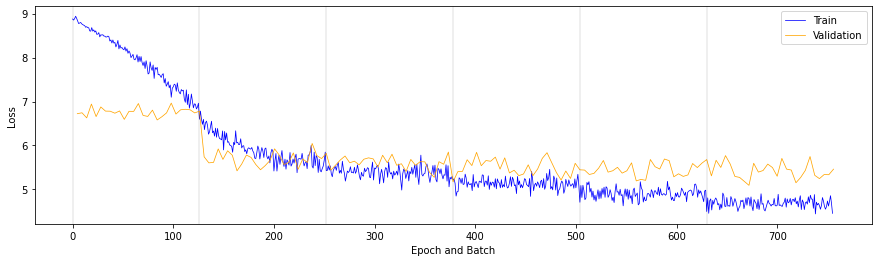

In [ ]:
matplotlib.rc('figure', figsize=(15,4))
val_ticks = [(i+1)*len(losses['train'])/len(losses['val']) for i in range(len(losses['val']))]
plt.plot(range(len(losses['train'])), losses['train'], c='blue', lw=0.75)
plt.plot(val_ticks, losses['val'], c='orange', lw=0.75)
for i in range(args.num_epochs):
    plt.axvline(x=i*len(losses['train'])/args.num_epochs, c='black', lw=0.25, alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

In [ ]:
y_pred.shape

torch.Size([500, 6138])

In [ ]:
batch_dict['x_data'].shape

torch.Size([500, 6])

In [ ]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)
loss_func = nn.CrossEntropyLoss()

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(x_in=batch_dict['x_data'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc


In [ ]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 6.286171701219345;
Test Accuracy: 18.762962962962963


### Trained Embeddings

In [ ]:
def pretty_print(results):
    """
    Pretty print embedding results.
    """
    for item in results:
        print (f"dist = {item[1]:.2f} for word: {item[0]}")

def get_closest(target_word, word_to_idx, embeddings, n=5):
    """
    Get the n closest
    words to your word.
    """

    # Calculate distances to all other words
    
    word_embedding = embeddings[word_to_idx[target_word.lower()]]
    distances = []
    for word, index in word_to_idx.items():
        if word == "<MASK>" or word == target_word:
            continue
        distances.append((word, torch.dist(word_embedding, embeddings[index])))
    
    results = sorted(distances, key=lambda x: x[1])[1:n+2]
    return results


In [ ]:
word = input('Enter a word: ')
embeddings = classifier.embedding.weight.data
word_to_idx = vectorizer.cbow_vocab._token_to_idx
pretty_print(get_closest(word, word_to_idx, embeddings, n=5))

Enter a word: fire
dist = 7.47 for word: fields
dist = 7.50 for word: lessened
dist = 7.62 for word: teacher
dist = 7.62 for word: reality
dist = 7.65 for word: teased
dist = 7.67 for word: advise


In [ ]:
embeddings.shape

torch.Size([6138, 50])

In [ ]:
#target_words = ['frankenstein', 'monster', 'science', 'sickness', 'lonely', 'eye']

#target_words = ['frankenstein', 'monster', 'mad', 'different', 'man']

target_words = ['frankenstein', 'monster', 'science', 'sickness', 'lonely']
embeddings = classifier.embedding.weight.data
word_to_idx = vectorizer.cbow_vocab._token_to_idx

for target_word in target_words: 
    print(f"======={target_word}=======")
    if target_word not in word_to_idx:
        print("Not in vocabulary")
        continue
    pretty_print(get_closest(target_word, word_to_idx, embeddings, n=5))

=======frankenstein=======
dist = 6.98 for word: burdened
dist = 7.00 for word: almighty
dist = 7.08 for word: judgment
dist = 7.14 for word: obscure
dist = 7.31 for word: degenerating
dist = 7.32 for word: nearly
=======monster=======
dist = 6.40 for word: circumstantial
dist = 6.52 for word: workshop
dist = 6.54 for word: dared
dist = 6.61 for word: arteries
dist = 6.64 for word: sometimes
dist = 6.69 for word: shapes
=======science=======
dist = 6.95 for word: reasonably
dist = 7.03 for word: need
dist = 7.09 for word: constantinople
dist = 7.13 for word: angel
dist = 7.15 for word: stole
dist = 7.15 for word: burning
=======sickness=======
dist = 7.04 for word: art
dist = 7.21 for word: coleridge
dist = 7.24 for word: whom
dist = 7.28 for word: slackened
dist = 7.40 for word: loathed
dist = 7.41 for word: write
=======lonely=======
dist = 6.97 for word: mistake
dist = 7.00 for word: immeasurably
dist = 7.13 for word: recovery
dist = 7.16 for word: material
dist = 7.21 for word: los

In [ ]:
embs = classifier.embedding.weight.detach().numpy()
embs.shape

(6138, 50)

In [ ]:
emb_words = list(vectorizer.cbow_vocab._idx_to_token.values())
emb_words[:10]

['<MASK>',
 '<UNK>',
 ',',
 'or',
 'the',
 'frankenstein',
 'modern',
 'prometheus',
 'by',
 'mary']

In [ ]:
from sklearn.manifold import TSNE

embs_red = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=15).fit_transform(embs)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [ ]:
df_embs = pd.DataFrame({'word':emb_words, 'x':embs_red[:,0], 'y':embs_red[:,1]})

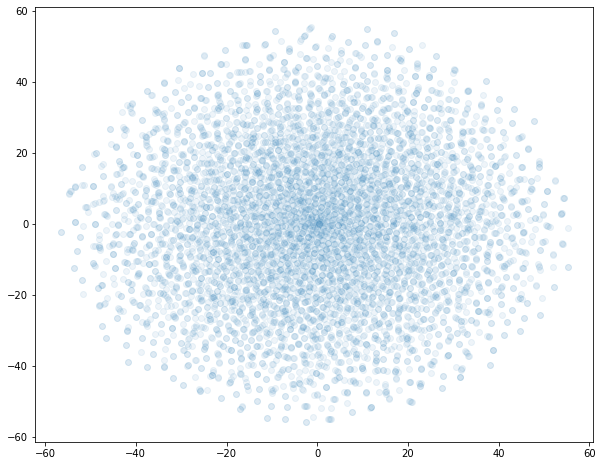

In [ ]:
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(df_embs.x, df_embs.y, alpha=.075);

In [ ]:
def plot_bg(bg_alpha=.01, figsize=(13, 9), emb_2d=None):
    """Create and return a plot of all embeddings with very low opacity.
    (Intended to be used as a basis for further plotting of a 
    subset of words.)
    """
    if emb_2d is None:
        emb_2d = embs_red
    fig, ax = plt.subplots(figsize=figsize)
    X = emb_2d[:, 0]
    Y = emb_2d[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax

#def annotate_sample(n, n_ratings_thresh=0):
#    """Plot our embeddings with a random sample of n words annotated.  """
#    sample = mainstream_movies[mainstream_movies.n_ratings >= n_ratings_thresh].sample(
#        n, random_state=1)
#    plot_with_annotations(sample.index)

def plot_by_pattern(pattern, **kwargs):
    """Plot all words matching the given regex pattern. """
    match_idx = df_embs.word.str.contains(pattern)
    match_idx.fillna(value=False, inplace=True)
    match = df_embs[match_idx]
    return plot_with_annotations(match.index, **kwargs)

def add_annotations(ax, label_indices, emb_2d=None, **kwargs):
    if emb_2d is None:
        emb_2d = embs_red
    X = emb_2d[label_indices, 0]
    Y = emb_2d[label_indices, 1]
    ax.scatter(X, Y, **kwargs)

def plot_with_annotations(label_indices, labels=None, alpha=1, **kwargs):
    ax = plot_bg(**kwargs)
    Xlabeled = embs_red[label_indices, 0]
    Ylabeled = embs_red[label_indices, 1]
    if labels is not None:
        for x, y, label in zip(Xlabeled, Ylabeled, labels):
            ax.scatter(x, y, alpha=alpha, label=label, marker='1',
                       s=90,
                      )
        fig.legend()
    else:
        ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color='green')
    
    return ax


FS = (13, 9)
def plot_region(x0, x1, y0, y1, text=True):
    """Plot the region of the mapping space bounded by the given x and y limits.
    """
    fig, ax = plt.subplots(figsize=FS)
    pts = df_embs[
        (df_embs.x >= x0) & (df_embs.x <= x1)
        & (df_embs.y >= y0) & (df_embs.y <= y1)
    ]
    ax.scatter(pts.x, pts.y, alpha=.6)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    if text:
        texts = []
        for label, x, y in zip(pts.word.values, pts.x.values, pts.y.values):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, expand_text=(1.01, 1.05))
    return ax

def plot_region_around(word, margin=5, **kwargs):
    """Plot the region of the mapping space in the neighbourhood of the given word. 
    The margin parameter controls the size of the neighbourhood around the word.
    """
    xmargin = ymargin = margin
    match = df_embs[df_embs.word == word]
    if len(match) != 1:
      print(f"len(match) = {len(match)}, but should be 1")
      return
    row = match.iloc[0]
    return plot_region(row.x-xmargin, row.x+xmargin, row.y-ymargin, row.y+ymargin, **kwargs)

In [ ]:
try:
    from adjustText import adjust_text
except ImportError:
    def adjust_text(*args, **kwargs):
        pass


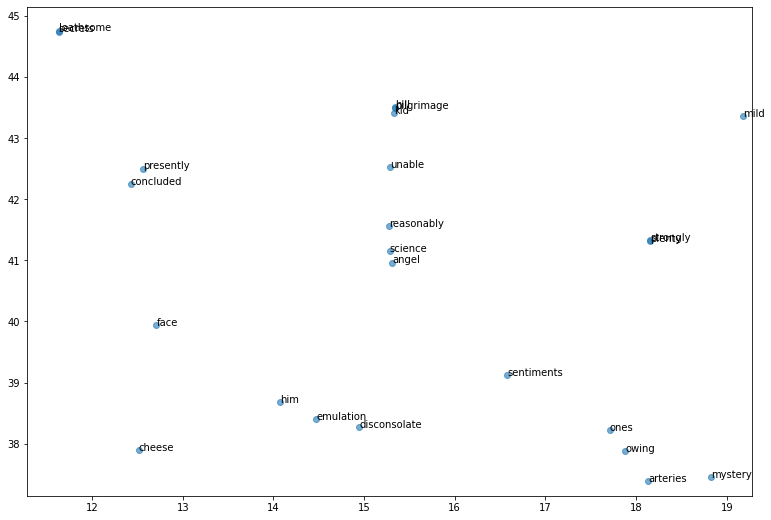

In [ ]:
plot_region_around('science', margin=4);

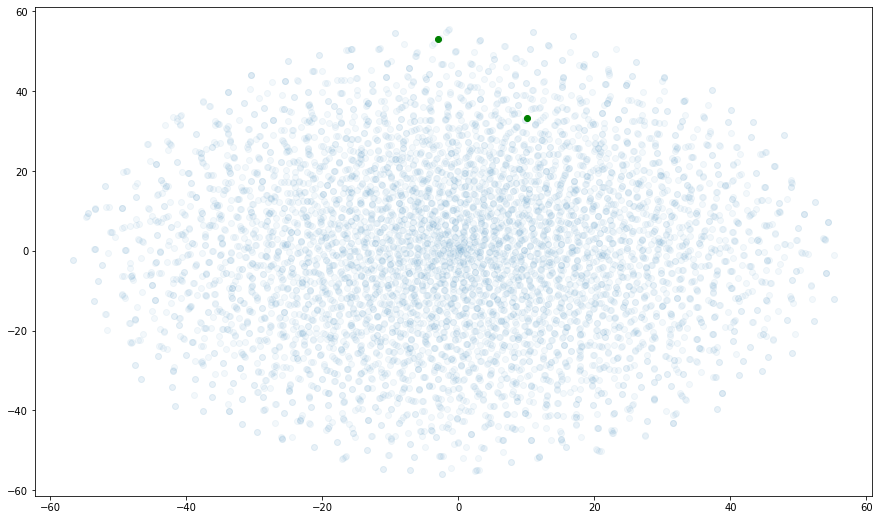

In [ ]:
plot_by_pattern('fire', figsize=(15, 9), bg_alpha=.05)